# Term Paper TECH2

## Candidate Numbers: 4, 18, 60


## Part 1 - Reading in the data

### Part 1.1

In [753]:
# Libraries used for data handling, plotting and calculations
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [754]:
def importing_csvs(name_prefix, filetype, sep, date_col):
    """
    Import all files matching {name_prefix}*.{filetype} in data_path_ and return a concatenated DataFrame.

    Parameters:
    - name_prefix (str): The prefix of the file names to match.
    - filetype (str): The file extension/type (e.g., 'csv').
    - sep (str): The separator used in the CSV files.
    - date_col (str): The name of the column to parse as dates.

    Returns a pandas DataFrame containing the concatenated data from all matched files.
    """

    # Define the file pattern, with a wildcard after the name_prefix
    pattern = f"./data/{name_prefix}*.{filetype}"

    # Initialize an empty list to hold DataFrames
    dfs = []

    # Loop through files matching the file pattern and read them into DataFrames
    # Append each DataFrame to the list named dfs
    # Parse the date_col as dates and use the specified separator
    for fp in glob.glob(pattern):
        d = pd.read_csv(fp, parse_dates=[date_col], sep=sep)
        dfs.append(d)

    # Safety check: if no files matched, return an empty DataFrame instead of error message
    if not dfs:
        print(f"No files matched pattern: {pattern}")
        return pd.DataFrame()

    # Concatenate all DataFrames into a single DataFrame named df_output
    df_output = pd.concat(dfs, ignore_index=True)

    # Return the concatenated DataFrame
    return df_output

In [755]:
# Import the original SCE CSV files into a DataFrame, using function (importing_csvs)
df_original = importing_csvs("SCE", "csv", ";", "date")

### Part 1.2

In [756]:
# Function to compute and print overview statistics
# Using this for original DataFrame and cleaned DataFrame later
def overview_stats(data):

    # Finding number of unique users
    unique_ids = data["userid"].nunique()
    print(f"Number of unique users: {unique_ids}")

    # Finding number of data rows
    data_rows = data.shape[0]
    print(f"Number of data rows: {data_rows}")

    # Finding number of unique waves
    unique_waves = data["wid"].nunique()
    print(f"Number of unique waves: {unique_waves}")

    # Finding date range
    first_date = data["date"].min()
    last_date = data["date"].max()

    # Printing first and last dates observed
    print(f"Data ranges from {first_date.date()} to {last_date.date()}")

    # No return value, since we are just printing the statistics
    return None

In [757]:
# Using the function to get overview statistics of the original DataFrame
overview_stats(df_original)

Number of unique users: 23369
Number of data rows: 176101
Number of unique waves: 139
Data ranges from 2013-06-01 to 2024-12-31


## Part 2:  Data pre-processing

### Part 2.1

In [758]:
# Sort by 'userid' and 'date'
# Creating new dataframe (df) to avoid modifying original dataframe (df_original)

# Sorting and ensuring 'date' is datetime
# Setting 'userid' as index for grouping
df = df_original.sort_values(["userid", "date"], ignore_index=True)

# Could have looped through columns but this is clearer
num_cols = [c for c in df.columns if "num_lit_" in c and "_correct" in c]

# Fill missing values with the first observed value per user
# Using lambda function to forward-fill and backward-fill missing values
df[num_cols] = df.groupby("userid")[num_cols].transform(lambda x: x.ffill().bfill())

### Part 2.2 

In [759]:
# Demographic columns: age, gender, education
demo = ["age", "female", "educ"]

# Expectation columns: inflation, changes in house prices and the probability of the stock market increasing
EXPECTATION_COLS = ["inflation", "house_price_change", "prob_stocks_up"]

# Define subsets and drop NAs accordingly
subsets = [
    ("demo", demo),
    ("expectation", EXPECTATION_COLS),
    ("numeracy", num_cols),  # num_cols defined in previous cell
]

In [760]:
def drop_na_in_subsets(df, subsets):
    """
    Drop rows with NAs in specified subsets of columns and print statistics.
    Parameters:
    - df: DataFrame to process
    - subsets: List of tuples (name, list_of_columns) defining subsets to check for NAs
    """
    # Initialize total dropped rows counter
    total_rows_dropped = 0

    # Loop through subsets and drop rows with NAs
    for name, ss in subsets:
        # Get number of rows before dropping NAs
        before = df.shape[0]

        # Drop rows with NAs in the specified subset of columns
        df = df.dropna(subset=ss, ignore_index=True)

        # Get number of rows after dropping NAs
        after = df.shape[0]
        # Update total dropped rows
        total_rows_dropped += before - after

        print(
            f"Numbers before dropping NAs for {name}: {before}, after: {after}, dropped: {before - after}"
        )

    print(f"\nTotal rows dropped: {total_rows_dropped}")

    # Return the cleaned DataFrame
    return df

In [761]:
# Apply the function to drop NAs in specified subsets
df = drop_na_in_subsets(df, subsets)

Numbers before dropping NAs for demo: 176101, after: 175233, dropped: 868
Numbers before dropping NAs for expectation: 175233, after: 173550, dropped: 1683
Numbers before dropping NAs for numeracy: 173550, after: 137576, dropped: 35974

Total rows dropped: 38525


### Part 2.3

In [762]:
def drop_outliers(data, columns):
    """
    Drops outliers based on the 0.1th and 99.9th percentiles for each column.
    Drops values equal to or beyond these cutoffs.
    Reports outliers dropped per column and in total.
    """
    bounds = {}
    for col in columns:
        low, high = data[col].quantile([0.001, 0.999])
        bounds[col] = (low, high)

    total_dropped = 0
    mask = np.ones(len(data), dtype=bool)

    for col, (low, high) in bounds.items():
        col_mask = (data[col] > low) & (data[col] < high)
        dropped = (~col_mask).sum()
        total_dropped += dropped
        print(f"Observations dropped for {col}: {dropped}")
        mask &= col_mask

    print(f"\nTotal unique outliers dropped: {len(data) - mask.sum()}")
    return data[mask]

In [763]:
# Using the function to drop outliers in expectation variables
df = drop_outliers(df, EXPECTATION_COLS)

Observations dropped for inflation: 434
Observations dropped for house_price_change: 371
Observations dropped for prob_stocks_up: 2574

Total unique outliers dropped: 3178


### Part 2.4

In [764]:
# Creating a dummy variable for bachelors degree
df["college"] = (df["educ"] == 4).astype(int)

### Part 2.5

In [765]:
# Calculate number of correct answers per user
num_correct = df.groupby("userid")[num_cols].first().sum(axis=1)

# value counts normalized to fractions
fraction = num_correct.value_counts(normalize=True).sort_index() * 100

# display results
summary = (
    fraction.rename("percent").reset_index().rename(columns={"index": "num_correct"})
)
print(round(summary, 1))

   num_correct  percent
0          0.0      0.1
1          1.0      0.7
2          2.0      2.4
3          3.0      5.7
4          4.0     10.5
5          5.0     16.9
6          6.0     27.4
7          7.0     36.3


In [766]:
# Create a new column num_lit_high (“high numerical literacy”) equal to 1 if an individual had
# More correct responses than the median, and 0 otherwise."

# Calculate the median number of correct responses
median_num_correct = num_correct.median()
# Create the num_lit_high column with a dummy variable if a user had more correct responses than the median
num_lit_high = (num_correct > median_num_correct).astype(int)

# Add it to the dataframe by userid
df["num_lit_high"] = df["userid"].map(num_lit_high)

### Part 2.6

In [767]:
# Use function to print overview statistics of cleaned data
overview_stats(df)

Number of unique users: 17608
Number of data rows: 134398
Number of unique waves: 117
Data ranges from 2015-04-02 to 2024-12-31


## Part 3: Average expectations by group 
**Governor's Question:** Do average expectations of inflation, house prices, and stock markets differ across gender, education, and numeracy (or numerical literacy, the ability to perform simple numerical tasks)?

### Part 3.1 


In [768]:
def analyze_expectations_by_group(data, group_var, group_labels):
    """
    Calculate average expectations by group.

    Parameters:
    - data: DataFrame containing the data
    - group_var: string, column name for grouping ('female', 'college', 'num_lit_high')
    - group_labels: tuple of strings for group labels

    """
    # Calculate means for each expectation variable by group
    means = data.groupby(group_var)[EXPECTATION_COLS].mean()

    # Rename index values to more descriptive labels
    means.index = group_labels

    # Round to 2 decimal places for cleaner output
    means = means.round(1)

    # Return means for further use
    return means

We alternatively could have written this as a single function combined with the upcoming cell, but this is more explicit and easier to read. It also makes for easier access to calculating intermediate means per group if needed. That would look like this:

```python
def plot_expectations_by_group2(data, group_var, group_labels, title, return_stats=False):
    """Compute means and plot in one go."""
    means = data.groupby(group_var)[expectation].mean().round(1)
    means.index = group_labels
   
    fig, axes = plt.subplots(1, 3, figsize=(13, 5))
    fig.suptitle(title, fontsize=16, weight="bold")
   
    ylims = {"inflation": (0, 15), "house_price_change": (0, 15), "prob_stocks_up": (0, 100)}
   
    for i, var in enumerate(expectation):
        axes[i].bar(group_labels, means[var], color=["darkblue", "salmon"])
        axes[i].set_title(var.replace("_", " ").capitalize())
        axes[i].set_ylabel("Expectation (%)" if i < 2 else "Probability (%)")
        axes[i].set_ylim(ylims[var])
       
        for n, value in enumerate(means[var]):
            axes[i].text(n, value + ylims[var][1] * 0.02, f"{value}%",
                        ha="center", va="bottom")
   
    plt.tight_layout()
    return (fig, axes, means) if return_stats else (fig, axes)



### Part 3.2

In [769]:
def plot_expectations_by_group(data, group_var, group_labels, title):
    """
    Create bar plots of expectations by group with specific y-axis ranges.

    """
    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(13, 5))
    fig.suptitle(title, fontsize=16, weight="bold")

    # Define y-axis ranges for each expectation variable
    ylims = {
        "inflation": (0, 15),
        "house_price_change": (0, 15),
        "prob_stocks_up": (0, 100),
    }

    # Use the analyze_expectations_by_group function to get means for all expectation vars
    means_df = analyze_expectations_by_group(data, group_var, group_labels)

    # Loop through each expectation variable to create individual bar plots
    for i in range(3):
        expectation_var = EXPECTATION_COLS[i]

        # Extract the series of means for the current expectation variable
        means = means_df[expectation_var]

        # Create bar plot for the current expectation variable and set title
        axes[i].bar(group_labels, means.values, color=["darkblue", "salmon"])
        axes[i].set_title(expectation_var.replace("_", " ").capitalize())

        # Set y-axis labels and limits
        axes[i].set_ylabel("Expectation (%)" if i < 2 else "Probability (%)")

        # Set specific y-axis range for the expectation variable (e.g., inflation...)
        axes[i].set_ylim(ylims[expectation_var])

        # Show values on top of bars. Uses enumarate to return both index and value for each item
        # n is index of the bar while value is the height of the bar
        for n, value in enumerate(means.values):
            axes[i].text(
                n,  # x-coordinate
                value
                + (ylims[expectation_var][1] * 0.02),  # y-coordinate relative to y-lim
                f"{value}%",  # Text content
                ha="center",  # Horizontal alignment to center
                va="bottom",
            )  # Vertical alignment to bottom

    plt.tight_layout()
    plt.show()

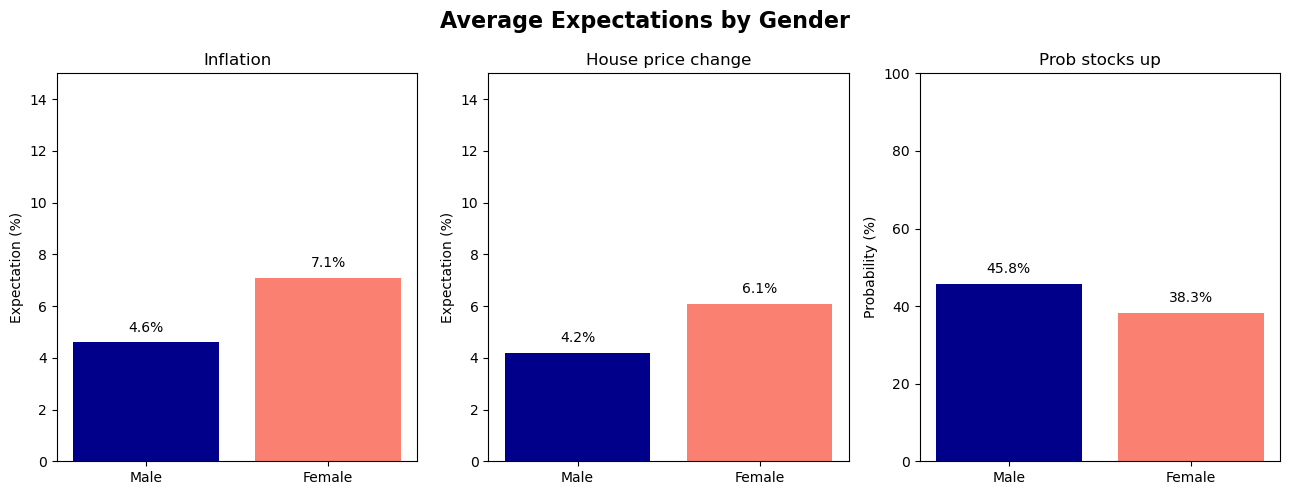

In [770]:
# Plot expectations by
plot_expectations_by_group(
    df, "female", ("Male", "Female"), "Average Expectations by Gender"
)

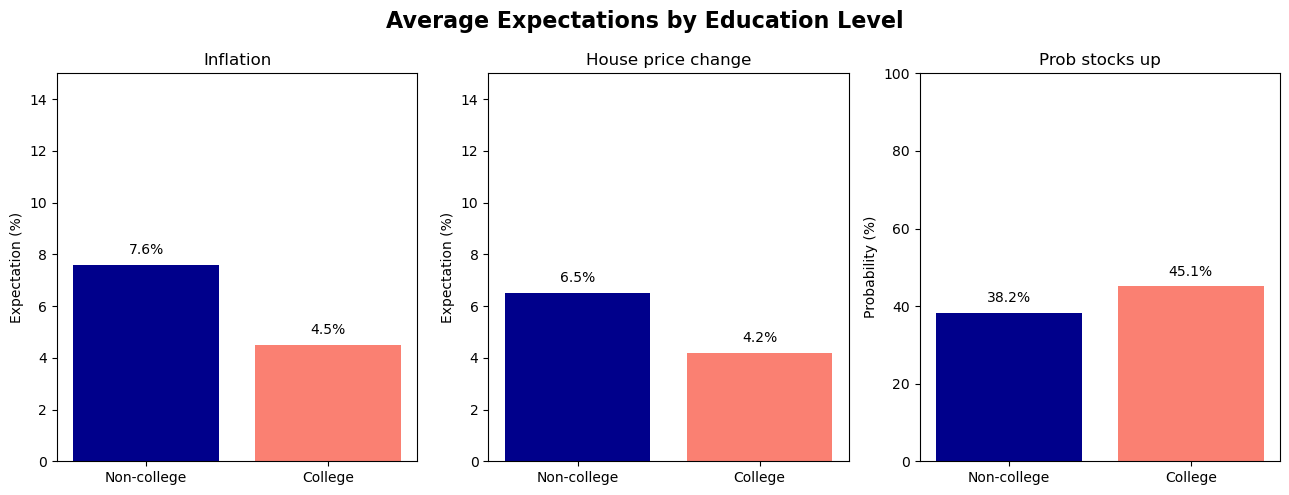

In [771]:
# Plot expectations by education level
plot_expectations_by_group(
    df, "college", ("Non-college", "College"), "Average Expectations by Education Level"
)

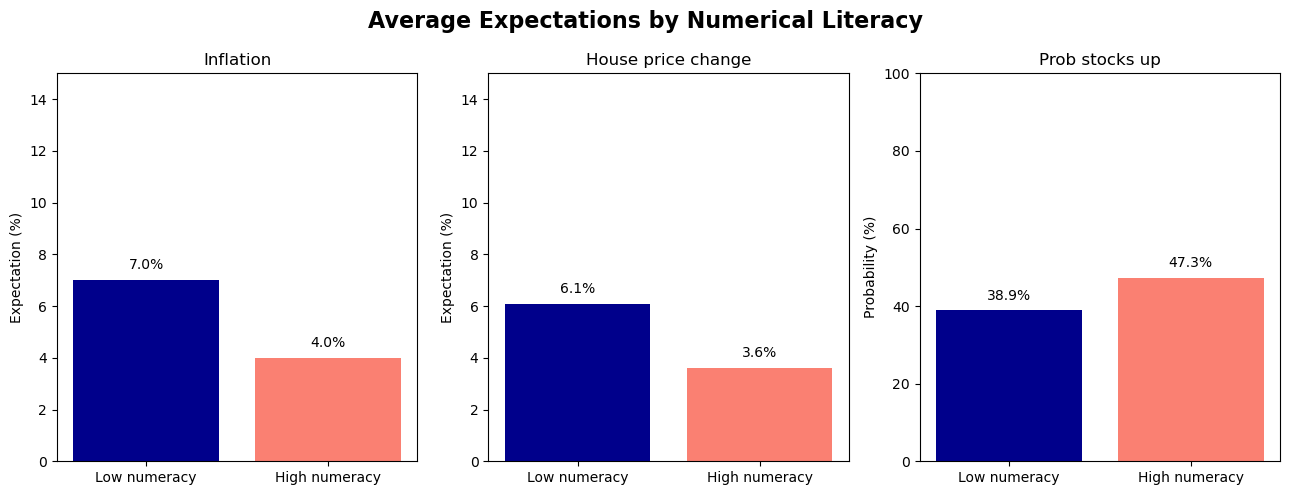

In [772]:
# Plot expectations by numerical literacy
plot_expectations_by_group(
    df,
    "num_lit_high",
    ("Low numeracy", "High numeracy"),
    "Average Expectations by Numerical Literacy",
)

## Conclusion: Task 3 — How do expectations differ by gender, education, and numeracy?

The results reveal consistent differences in expectations across groups.

---

#### **Gender**
As shown in the graph, women expect around 7% inflation and 6% house price growth, compared to men's 4.5% and 4%, respectively. They also assign a lower probability (≈38%) that stocks will rise versus men (≈45%). This indicates that women are generally more concerned about rising prices and more cautious toward stock market risk.

#### **Education Level**
The graph shows that non-college respondents expect about 7.5% inflation and 6.5% house price growth, while college-educated individuals predict around 4.5% and 4%. College-educated respondents also expect a higher 45% probability that stocks will increase, compared to 38% for non-college participants. This suggests that higher education is linked to more moderate and economically grounded expectations.

#### **Literacy Level**
As shown in the graph, people with low numeracy expect around 7% inflation and 6% house price growth, while high-numeracy individuals expect only about 4% and 3.6%, respectively. This likely reflects that people with stronger numerical skills make more realistic, data-based judgments. Similarly, high-numeracy individuals see about a 47% chance of stock prices rising, compared to 39% for low numeracy, suggesting they better understand market probabilities.

---

### Summary

Overall, people with higher numeracy or education have more moderate and realistic expectations: lower predicted inflation and house price growth but higher confidence in the stock market. In contrast, those with lower numeracy, less education, or women expect higher prices and show more caution toward financial risk.

## Part 4: Expectation dynamics by group
**Governor's Question:**Do expectation dynamics over time differ across these groups, and how do important geopolitical
events affect these expectations?

### Part 4.1

In [773]:
def monthly_group_means(df, group_col, date_col="date"):
    """
    Calculates monthly averages of expectation variables for each group.

    Returns three DataFrames (infl, house, stock),
    each showing average values per group for each month (2015–2024).

    Parameters:
    - df: DataFrame containing the data
    - group_col: string, column name
    - date_col: string, column name for dates (default is "date")

    """

    # Keep only the relevant columns (date, group, and expectation variables)
    df_monthly = df[[date_col, group_col] + EXPECTATION_COLS].copy()

    # Group by month and group value, then compute the mean of expectation columns
    # Using pd.Grouper to group by month end, and also group_col, then taking the average of each expectation variable
    gb = df_monthly.groupby([pd.Grouper(key="date", freq="ME"), group_col])[
        EXPECTATION_COLS
    ].mean()

    # For each expectation variable, reshape so that:
    # rows = months, columns = groups
    # limit the range to Jan 2015 – Dec 2024 as required in the task
    inflation, house_price, stock_prob = (
        gb[var]
        .unstack(group_col)
        .loc["2015-01":"2024-12"]  # Uses unstack to reshape, suggestion from CoPilot
        for var in EXPECTATION_COLS  # Loop through expectation variables
    )

    # Return the three DataFrames
    return inflation, house_price, stock_prob

### Part 4.2 and 4.3

In [774]:
# Define significant event dates as pandas Timestamps
ts = pd.Timestamp
events = {
    "Trump (1st)": ts("2016-11-08"),
    "COVID-19": ts("2020-02-01"),
    "Biden elected": ts("2020-11-03"),
    "Russia invades Ukraine": ts("2022-02-24"),
    "Jon Fosse Nobel Prize": ts("2023-10-03"),
    "Trump (2nd)": ts("2024-11-05"),
}

In [775]:
def create_monthly_group_plot(
    df, group_col, group_labels, custom_title, date_col="date"
):
    """
    Create the 3-panel monthly group means plot and return (fig, axes).
    Does not add event lines so they can be layered later.

    Parameters:
    - df: DataFrame containing the data
    - group_col: string, column name for grouping
    - group_labels: tuple of strings for group labels
    - custom_title: string for the overall plot suptitle
    - date_col: string, column name for dates (default is "date")

    """
    # Get monthly group means for each expectation variable by using previous function
    infl, house, stock = monthly_group_means(df, group_col, date_col)

    # Create figure with 3 vertical subplots, using gridspec to adjust spacing
    fig, axes = plt.subplots(3, 1, figsize=(14, 18), gridspec_kw={"hspace": 0.4})
    fig.suptitle(custom_title, fontsize=16, y=0.94, weight="bold")

    # Loop through each expectation variable to plot
    # Defining titles for each subplot
    for i, (data, title) in enumerate(
        zip(
            [infl, house, stock],
            [
                "Expected Inflation in 12 Months",
                "Expected Change in House Prices in 12 Months",
                "Probability of Stock Market Increase in 12 Months",
            ],
        )
    ):

        # Get the column names (groups) present in the data
        cols = data.columns.tolist()

        # Plot both group series (assumes two groups; uses whatever columns are present)
        axes[i].plot(
            data.index,
            data[cols[0]],
            label=group_labels[0],
            linewidth=2,
            color="darkblue",
        )  # data[cols[0]] = first group
        axes[i].plot(
            data.index,
            data[cols[1]],
            label=group_labels[1],
            linewidth=2,
            color="salmon",
        )  # data[cols[1]] = second group
        axes[i].set_title(title, fontsize=16, y=1.08)
        axes[i].set_ylabel("%", fontsize=12)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)  # Add grid with 30% opacity

        # Plotting circle markers at event dates, ignores the event name
        for _, ev_date in events.items():

            # Finds the index position in your time series data.index whose timestamp is closest to the event date.
            closest_idx = np.argmin(np.abs(data.index - ev_date))

            # Plot circle markers at those points, zorder=5 to ensure they appear above the lines
            axes[i].plot(
                data.index[closest_idx],
                data[cols[0]].iloc[closest_idx],
                marker="o",
                color="grey",
                markersize=6,
                zorder=5,
            )
            axes[i].plot(
                data.index[closest_idx],
                data[cols[1]].iloc[closest_idx],
                marker="o",
                color="grey",
                markersize=6,
                zorder=5,
            )

    # Set x-label for bottom plot and add horizontal line at y=0 for house price subplot
    axes[2].set_xlabel("Date")
    axes[1].axhline(0, color="black", lw=0.8)

    # Return the figure and axes
    return fig, axes

In [776]:
def add_event_lines(axes):
    """
    Add vertical event lines and labels to an existing axes array.
    The events dictionary is already defined globally.

    """

    # Loop through each event to add vertical lines and labels
    for event_name, event_date in events.items():
        for ax in axes:
            ax.axvline(
                event_date, color="grey", linestyle="--", alpha=0.8, linewidth=1.2
            )

            # Get current y-axis limits to position the label
            bottom, top = ax.get_ylim()

            # Calculate span of y-axis
            span = top - bottom

            # Add text label slightly above the top of the y-axis
            # Adding a small offset (2% of the span) above the top for better visibility
            # Aligning text to center horizontally and bottom vertically
            ax.text(
                event_date,
                top + span * 0.02,
                event_name,
                ha="center",
                va="bottom",
                fontsize=8,
                alpha=0.9,
            )

    return None

/var/folders/25/wpd8sltd5fl_pfs7dllz1bf40000gp/T/ipykernel_26464/2349123578.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


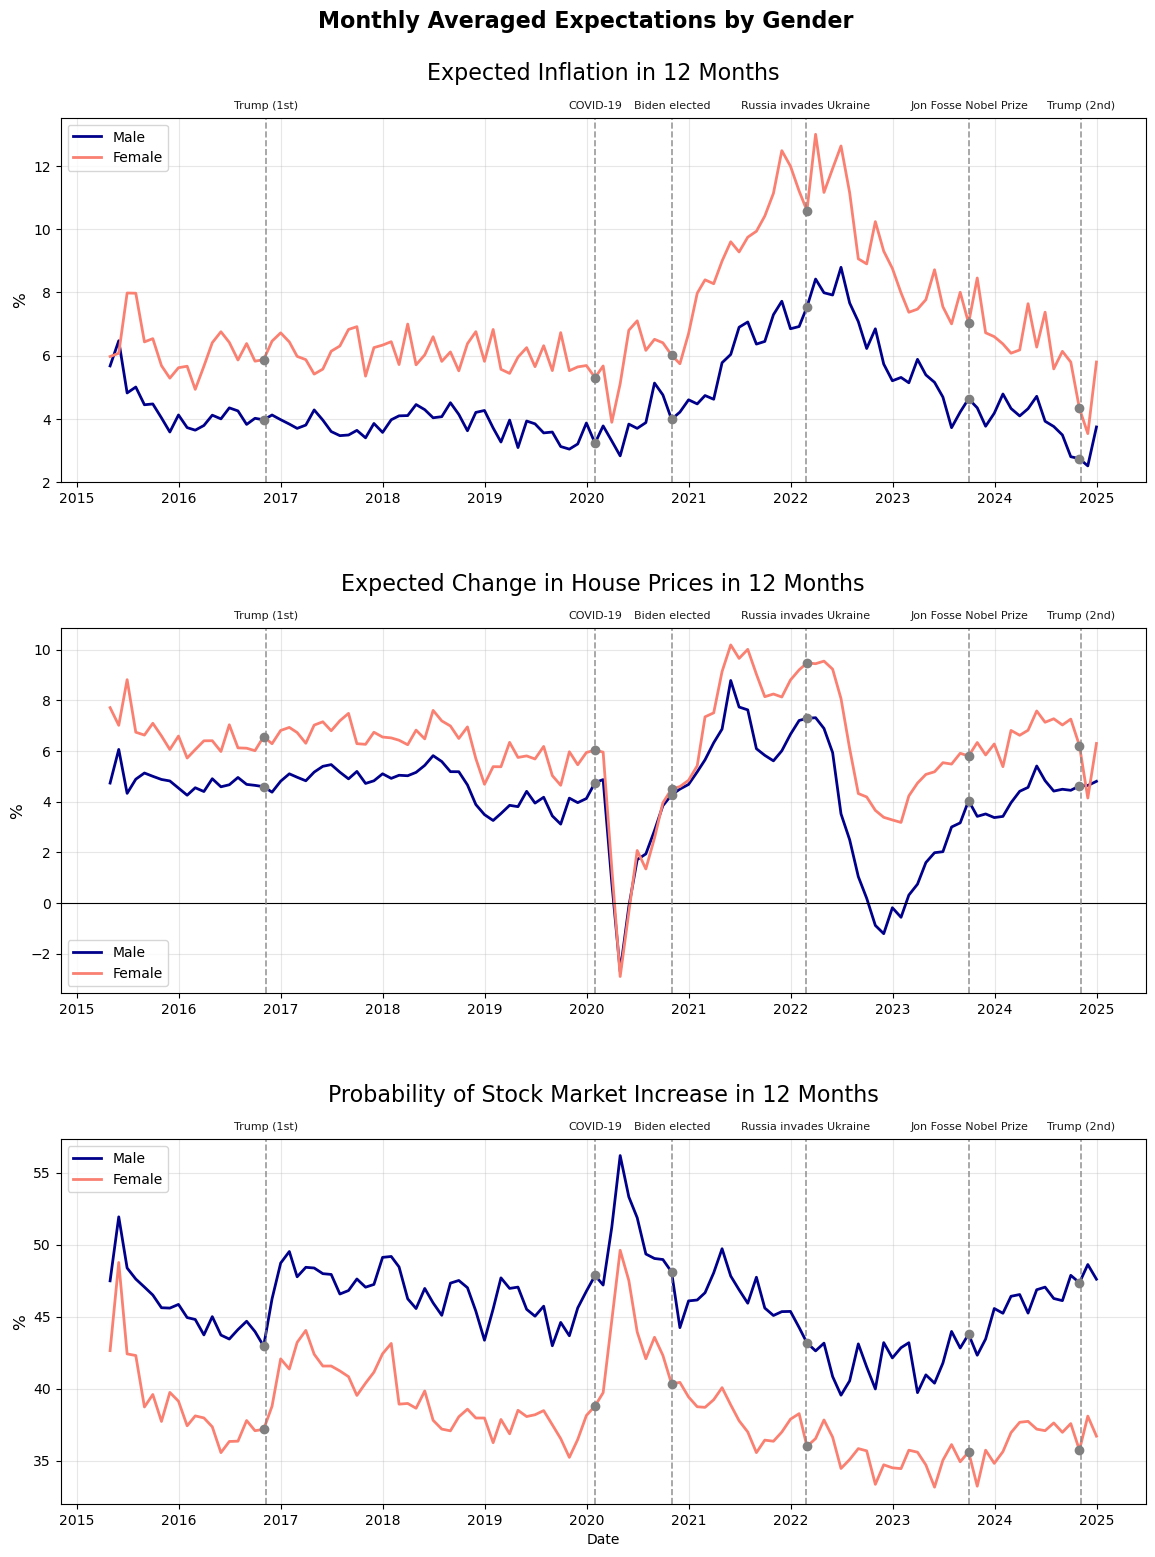

In [777]:
# Create monthly group plot for gender
fig, axes = create_monthly_group_plot(
    df, "female", ("Male", "Female"), "Monthly Averaged Expectations by Gender"
)

# Add event lines for the specific axes
add_event_lines(axes)

plt.tight_layout()
plt.show()

### **Sub-Conclusion (Gender):**
Expectations moved with the same shocks, but levels differed by gender.
Women generally reported higher 12-month inflation and house-price expectations than men, while men were typically more optimistic about the perceived probability of a 12-month stock-market increase.

***Pandemic:***
COVID-19 marked the dominant break for both groups. Inflation expectations rose sharply (peaking higher for women). House price expectations plunged in the same period, before rebounding (V-shape). The perceived probabilty of stock market increase also peaked in the months following the outbreak.

***Invasion:***
Around Russia's invasion of Ukraine in 2022, inflation expectations were high, but trend down until late 2024. The expected change in house prices also plunged for both genders. Housing expectations soften in late 2022/early 2023 after it briefly dipped below zero for the male respondants (female remained positive).

***Elections:***
Trump’s first election in 2016 raised stock market optimism for both genders. Biden’s 2020 election coincided with higher inflation and housing expectations, though likely driven by the post-COVID rebound rather than the election itself. Since the last data is gathered on 31. december 2024, the data could catch some of the effects of Trump's second election in 2024. Even though it is not a causal effect, the rise in inflation expectancy could be affected by the election. It is important to address that these are descriptive, event-timed patterns, not causal estimates. 


/var/folders/25/wpd8sltd5fl_pfs7dllz1bf40000gp/T/ipykernel_26464/3099436886.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


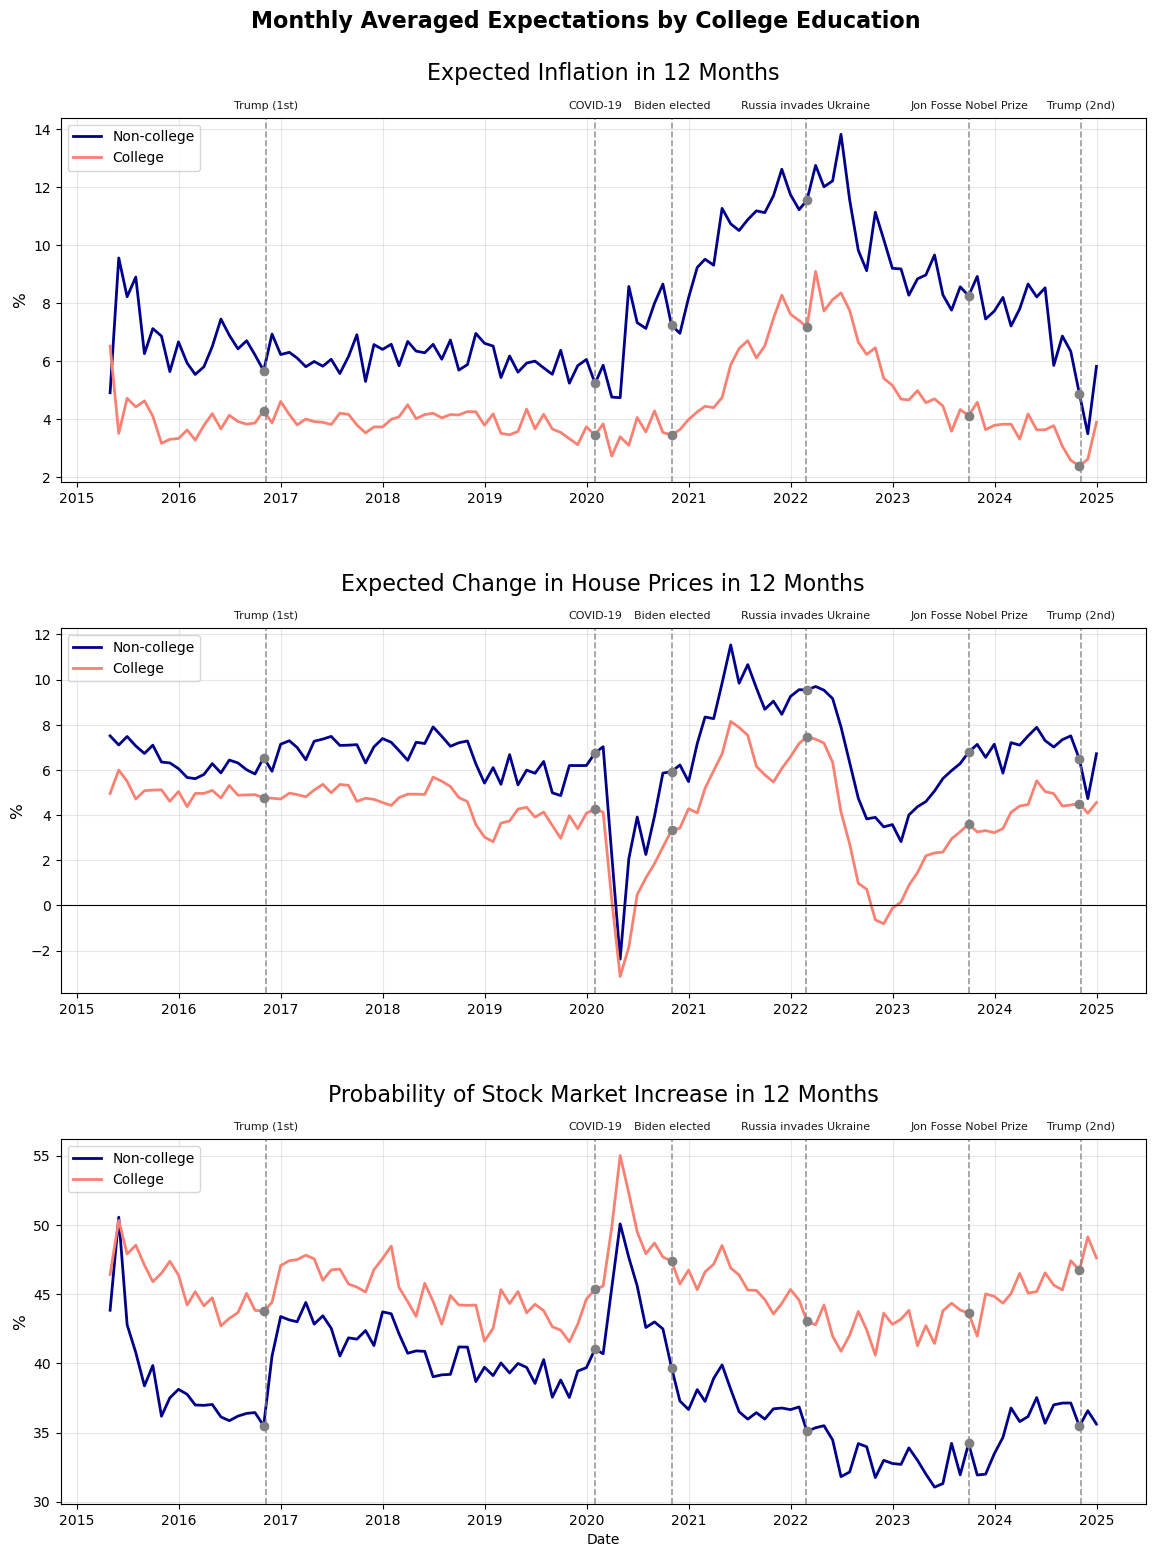

In [778]:
# Create monthly group plot for college education
fig, axes = create_monthly_group_plot(
    df,
    "college",
    ("Non-college", "College"),
    "Monthly Averaged Expectations by College Education",
)

# Add event lines for the specific axes
add_event_lines(axes)

plt.tight_layout()
plt.show()

### **Sub-Conclusion (Education Level):**
Overall, both groups moved with the same shocks. 
Around Russia’s invasion, inflation expectations started to cool, house-price expectations rolled over and plummeted for both groups, and stock optimism dropped. The differences were persistent where non-college respondents showed higher and more volatile inflation expectations (including a large COVID-19 spike and peaks in 2021–22) and a deeper housing drop with a stronger rebound. On the other hand, college respondents looked more anchored.
 
When it came to the probability of stock price increase, both groups' optimism spiked around the start of the epidemic, and then fell sharply. However, college respondents were consistently more optimistic about a 12-month market rise (several percentage points higher most of the time), while non-college optimism was about 5-10 percentage points lower and dropped to a much lower level. These patterns were consistent with greater shock sensitivity among the non-college respondents, even though the figures alone does not tell why.




/var/folders/25/wpd8sltd5fl_pfs7dllz1bf40000gp/T/ipykernel_26464/3973943523.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


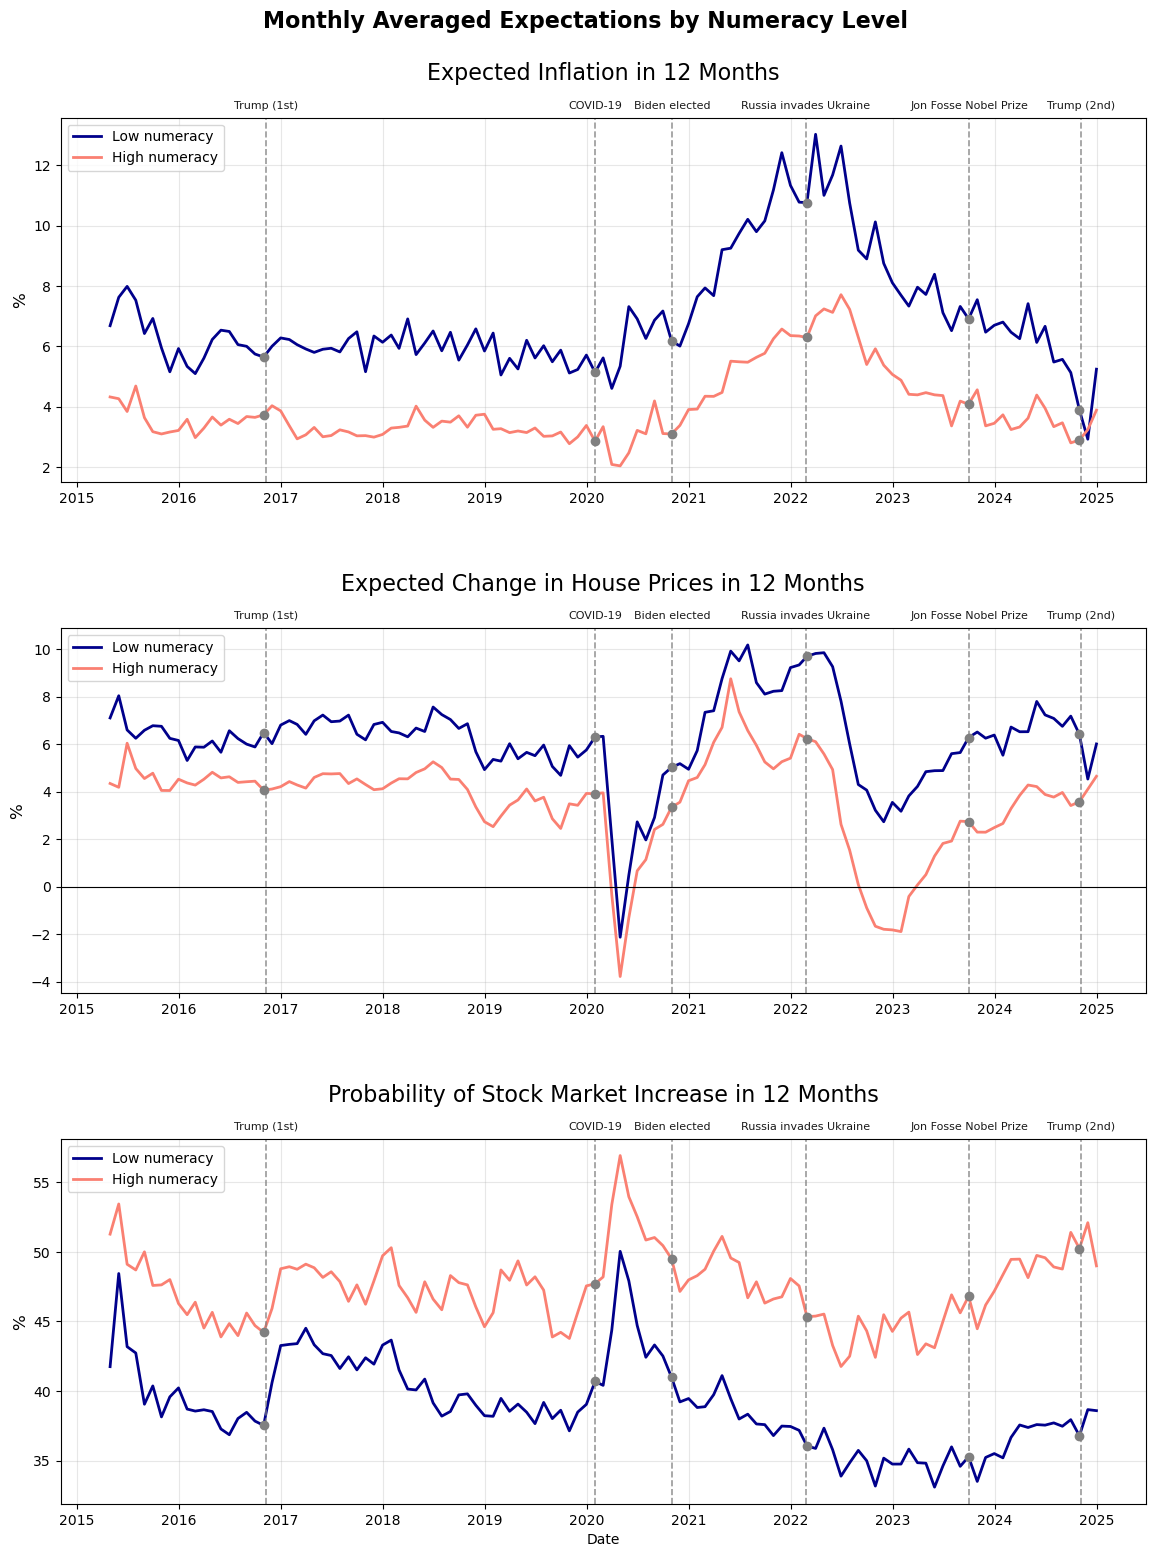

In [779]:
# Create monthly group plot for numerical literacy
fig, axes = create_monthly_group_plot(
    df,
    "num_lit_high",
    ("Low numeracy", "High numeracy"),
    "Monthly Averaged Expectations by Numeracy Level",
)

# Add event lines for the specific axes
add_event_lines(axes)

plt.tight_layout()
plt.show()

### **Sub-Conclusion (Numeracy Level):**
Generally, the two most noticable effects were the epidemic and the russian invasion.
COVID-19 triggered an inflation spike, a housing plunge with a V-shaped rebound, and a brief surge in stock optimism. 

The 2022 invasion marked a turning point. The inflation expectations dropped and cooled, housing expectations rolled over and fell into early-2023, and stock optimism dropped. Elections in 2016, 2020, 2024 had minor effects, but were not clearly identifiable from background trends.

Across the period, low-numeracy respondents had higher and more volatile inflation expectations (a larger COVID-19 spike, and higher 2021–22 peaks) and remained less pessimistic about hous-price expectations (rarely dipping below zero), whereas high-numeracy respondents were more pessimistic on housing during the downturn, but were consistently more optimistic about a potetntial stock-market rise. 


## Main Conclusion Part 4:

Despite several short-term shocks, two main macro shocks dominated: COVID-19 and Russia's 2022 invasion. The COVID-19 pandemic triggered a surge in 12-month inflation expectations, a collapse and V-shaped rebound in the expected change in house prices, and a brief spike in the perceived probability of a 12-month stock-market increase. After the invasion, inflation expectations cooled, house-price expectations rolled over and fell into early-2023, and stock optimism declined. Across the stock-probability panels,the 2016 election coincided with a small uptick. The 2020 and 2024 elections showed minor trends, while Jon Fosse's Nobel Prize did not show any discernible effect.

**Differences by Group**

***Gender:***
Women reported higher inflation and house-price expectations, while men were more optimistic about a 12-month stock-market rise.

***Education:***
Non-college respondents showed higher and more volatile inflation expectations and larger swings in house-price expectations. College respondents were typically more optimistic to a bullish stock market.

***Numeracy:***
Low-numeracy respondents reflected the non-college pattern (higher/less-anchored inflation and large housing swings), while high-numeracy respondents were more anchored and more optimistic to a rising stock-market.

**Differences/Similarities across Groups**

Across groups, anchoring differed in amplitude and persistence. For instance did non-college, low-numeracy and women show higher, more volatile inflation expectations, while college, high-numeracy and men looked more anchored on inflation and consistently more optimistic regarding the stock-market.

***Caution:***
These patterns are event-timed and descriptive,not causal estimates. Several moves begin before or unfold after the events. Therefore, attributing effects without a formal counterfactual could be misleading.


## Part 5: Correlations with past & future realizations
**Governor's Question:** Are expectations correlated with the actual outcomes, or are individuals more likely to extrapolate
from past experiences?

### Part 5.1


In [780]:
# Importing CPI.csv file using the previously defined function (importing_csvs, Part 1.1)
df_cpi = importing_csvs("CPI", "csv", ",", "DATE")

In [781]:
def prepare_cpi_inflation(mode):
    """
    Calculate inflation metrics from CPI data.

    Parameters:
    - mode: 'future' for realized inflation (CPI[t+12] vs CPI[t])
            'past' for past inflation (CPI[t] vs CPI[t-12])

    Returns a DataFrame with 'DATE' and 'Compared_Inflation' columns, which can be compared to expectation data.
    """
    # Copy the original CPI DataFrame to avoid modifying it
    df_result = df_cpi.copy()

    # Determine the sign for percentage change calculation based on mode
    # For calculating future and past inflation, we need to see correlation between future predictions and actual inflation
    # Also to calculate past inflation to see correlation with future predictions
    if mode == "future":
        coef_var = -1
    elif mode == "past":
        coef_var = 1
    else:
        raise ValueError("mode must be either 'future' or 'past'")

    # Calculate the percentage change in CPI over 12 months, adjusted by coef_var, for correlation analysis
    df_result["Compared_Inflation"] = (df_result["CPI"]).pct_change(
        periods=12 * coef_var
    ) * (100 * coef_var)
    df_result = df_result[["DATE", "Compared_Inflation"]].dropna().copy()

    # Return the resulting DataFrame
    return df_result

In [782]:
def df_cpi_merge_by_group(group_col, Name_column_1, Name_column_2, mode):
    """
    Merge CPI inflation data with monthly group means.

    Parameters:
    - group_col: string, column name for grouping ('female', 'college', 'num_lit_high')
    - Name_column_1: string, label for first group (e.g., 'Male')
    - Name_column_2: string, label for second group (e.g., 'Female')
    - Mode: Past or future correlation with expectation (From prepare_cpi_inflation function)

    Returns:
    DataFrame with DATE as index, group expectations, and realized/past inflation
    """
    # Using previously defined function to prepare CPI inflation data based on mode
    df_cpi_prepared = prepare_cpi_inflation(mode)

    # Get monthly group means for inflation expectations
    df_monthly_grouped = (
        monthly_group_means(df, group_col)[0]  # [0] to get inflation DataFrame
        .rename_axis("DATE")  # Rename index to 'DATE' to match CPI DataFrame
        .reset_index()  # Remove index to prepare for merging
        .rename(
            columns={0: Name_column_1, 1: Name_column_2}
        )  # Rename columns to group labels, for better visuals
    )

    # Shift monthly dates to beginning of month for merging
    df_monthly_grouped["DATE"] = df_monthly_grouped["DATE"] + pd.offsets.MonthBegin(1)

    # Merge with CPI data
    merged_inflation = (
        pd.merge(df_monthly_grouped, df_cpi_prepared, on="DATE", how="inner")
        .set_index("DATE")  # Set DATE as index
        .sort_index()
    )  # Sort by DATE

    # Return the merged DataFrame
    return merged_inflation

In [783]:
def plot_realized_vs_expected(merged_df_grouped, mode):
    """
    Create a scatter plot comparing realized or past inflation against expected inflation by gender.

    Parameters:
    - merged_df_grouped: DataFrame from df_cpi_merge_by_group
    - mode: 'future' for realized inflation or 'past' for past inflation

    Returns:
    None (displays the plot)
    """
    # Set up the figure and axes for 2 subplots which display correlation for each group
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Set the title for the entire figure based on the mode
    fig.suptitle(
        f'{"Realized" if mode == "future" else "Past"} vs. Expected Inflation by Gender',
        fontsize=16,
        weight="bold",
    )

    # Get the column names (excluding the inflation column)
    group_cols = merged_df_grouped.columns.drop("Compared_Inflation").tolist()

    # Loop through each group column to create individual scatter plots for the 2 subplots
    for i, col_name in enumerate(group_cols):

        ax = axes[i]  # Get the current axis for the subplot

        x = merged_df_grouped[col_name]  # Expected inflation for x-axis
        y = merged_df_grouped[
            "Compared_Inflation"
        ]  # Realized or past inflation for y-axis, based on mode

        # Create scatter plot
        ax.scatter(x, y, alpha=0.6, color="darkblue" if i == 0 else "salmon")

        # Set titles and labels
        ax.set_title(f"{col_name}", fontsize=14)

        # Set x and y labels
        ax.set_xlabel("Expected Inflation (%)", fontsize=12)
        ax.set_ylabel(
            f'{"Realized" if mode == "future" else "Past"} Inflation (%)', fontsize=12
        )

        # Calculate correlation coefficient, using numpy's corrcoef function, from Copilot suggestion
        corr_coef = np.corrcoef(x, y)[0, 1]

        # Add correlation coefficient as text to the plot
        ax.text(
            0.05,
            0.95,
            f"Correlation: {corr_coef:.2f}",
            transform=ax.transAxes,  # Positioning relative to axes
            fontsize=12,  # Font size for the text
            va="top",  # Vertical alignment to top
            # Box style for better visibility
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
        )

    plt.tight_layout()
    plt.show()

    return None

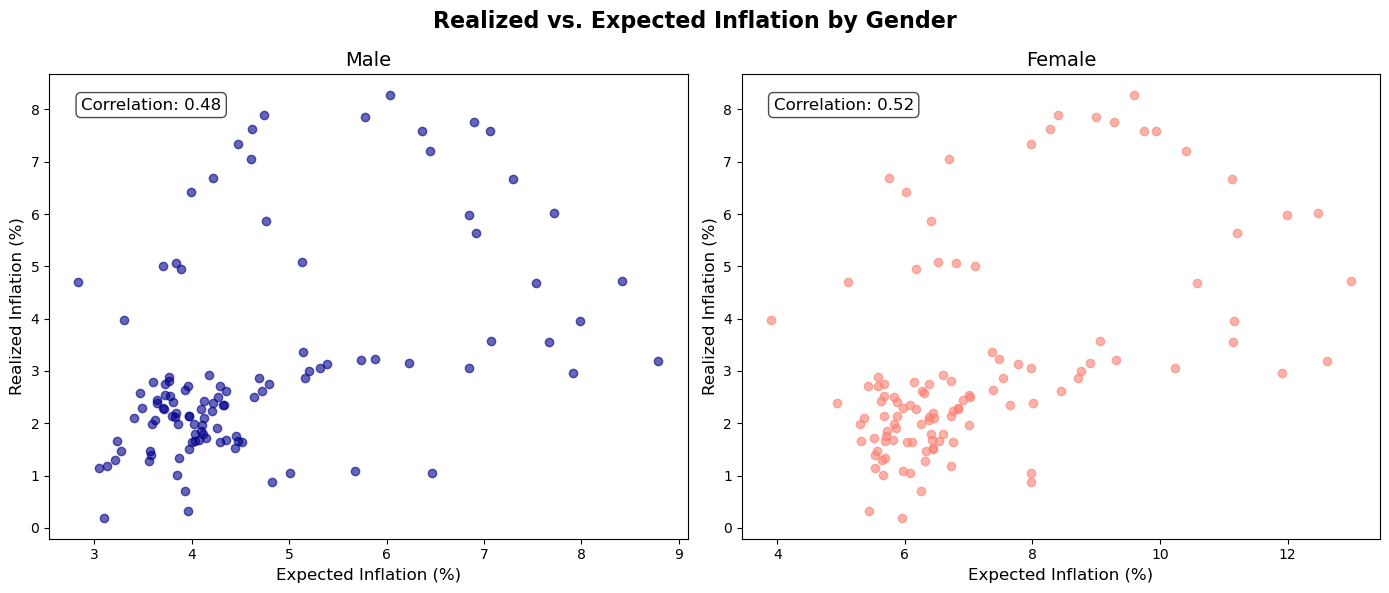

In [784]:
# Using function (df_cpi_merge_by_group) to get merged DataFrame
# Using that DataFrame to plot realized vs expected inflation by gender
df_female_future = df_cpi_merge_by_group("female", "Male", "Female", "future")
plot_realized_vs_expected(df_female_future, "future")

### Part 5.2
Some of part 5.2 is included in part 5.1, such as the calculations for pct_change and the correlation matrix.

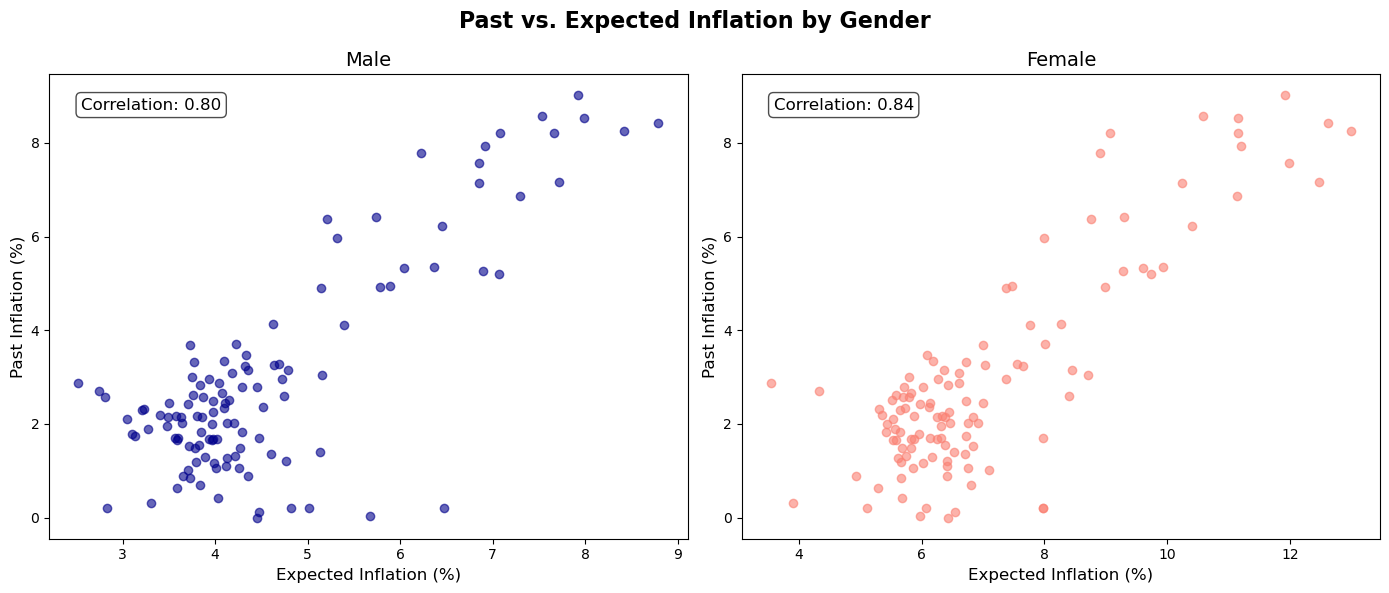

In [785]:
# Using function (df_cpi_merge_by_group) to get merged DataFrame
# Using that DataFrame to plot past vs expected inflation by gender
df_female_past = df_cpi_merge_by_group("female", "Male", "Female", "past")
plot_realized_vs_expected(df_female_past, "past")

## Part 5 Conclusion
From the scatter plots, it can be observed that the correlation between realized inflation and expected inflation was relatively low for both men and women, with values of 0.48 and 0.52 respectively. This indicates that respondents' inflation expectations did not strongly align with the actual outcomes. The slightly higher correlation among women suggests that their predictions were somewhat more accurate compared to those of men.

In contrast, the correlation between past inflation and expected inflation was considerably higher, at 0.80 for men and 0.84 for women. This strong relationship implies that both genders rely heavily on past inflation trends when forming their expectations about future inflation. Furthermore, the slightly higher correlation among women suggests that they depend somewhat more on historical data than men do.

Overall, these results indicate that individuals are more likely to base their expectations on past experiences rather than accurately forecasting future inflation outcomes. Women appear to be both more reliant on previous inflation patterns and slightly more precise in their future predictions.
